In [ ]:
!nvidia-smi

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# !cp '/gdrive/My Drive/Colab Notebooks/MarsSpectrometry2/val_labels.csv' 'val_labels.csv'

In [ ]:
!mkdir OOF
!mkdir submissions

In [ ]:
import itertools
from pathlib import Path
from pprint import pprint

from matplotlib import pyplot as plt, cm
import numpy as np
import pandas as pd
# from pandas_path import path
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold, cross_val_score
from tqdm import tqdm

pd.set_option("max_colwidth", 80)
RANDOM_SEED = 42  # For reproducibility

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import gc
import random

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
import scipy.stats as sp


from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import log_loss

In [ ]:
import joblib
model_path='/gdrive/My Drive/Colab Notebooks/MarsSpectrometry2/models2/'
oof_path='/gdrive/My Drive/Colab Notebooks/MarsSpectrometry2/OOF/'
subs_path='/gdrive/My Drive/Colab Notebooks/MarsSpectrometry2/submissions/'

In [ ]:
step=0.002
def clip_preds_perclass(oof, test_preds, step=0.002):
    clips_per_class=[]
    oof2=oof.copy()
    all_test_preds2=test_preds.copy()
    for x in range(9):
        # print(x)
        dc=0
        upc=1
        
        bestscore = log_loss(labels[:,x], np.clip(oof[:,x],dc, upc))
        # print(bestscore)
        # dc+=step
        if log_loss(labels[:,x], np.clip(oof[:,x],dc+step, upc))<bestscore:
            dc+=step
            newscore =  log_loss(labels[:,x], np.clip(oof[:,x],dc, upc))
            while newscore<bestscore:
                bestscore=newscore
                dc+=step
                newscore =  log_loss(labels[:,x], np.clip(oof[:,x],dc, upc))
        # print(dc, bestscore)

        # upc-=step
        if log_loss(labels[:,x], np.clip(oof[:,x],dc, upc-step))<bestscore:
            upc-=step
            newscore =  log_loss(labels[:,x], np.clip(oof[:,x],dc, upc))
            while newscore<bestscore:
                bestscore=newscore
                upc-=step
                newscore =  log_loss(labels[:,x], np.clip(oof[:,x],dc, upc))
        # print(upc, bestscore)
        clips_per_class.append([dc, upc])
        oof2[:,x]=np.clip(oof2[:,x], dc, upc)
        all_test_preds2[:,x]=np.clip(all_test_preds2[:,x], dc, upc)
        # print('----------------------------')
    return oof2, all_test_preds2

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
def preprocess_data(X, scaler=None):
    if not scaler:
        # scaler = MinMaxScaler((0,1))
        scaler = StandardScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # session_conf = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
#                                       inter_op_parallelism_threads=num_cores, 
#                                       allow_soft_placement=True,
#                                       device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})

#         sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#         K.set_session(sess)

# base_weights_dir='/gdrive/My Drive/Colab Notebooks/MarsSpectrometry2/weights/'
def print_scores(oof, test_preds):
    print('oof score',np.mean( [log_loss(labels[:,x], oof[:,x]) for x in range(9)]))
    oof2, all_test_preds2=clip_preds_perclass(oof, test_preds)
    print('oof score, clipped per c',np.mean( [log_loss(labels[:,x], oof2[:,x]) for x in range(9)]))
    print('val score', np.mean( [log_loss(val_labels.values[:,x], test_preds[:len(val_labels),x]) for x in range(9)]))
    print('val score, clipped per c',np.mean( [log_loss(val_labels.values[:,x], all_test_preds2[:len(val_labels),x]) for x in range(9)]))
    # np.mean( [log_loss(val_labels.values[:,x], np.clip(all_test_preds2[:len(val_labels),x],0.001, 0.995 )) for x in range(9)])
    print('mean score unclipped', 0.5*np.mean( [log_loss(labels[:,x], oof[:,x]) for x in range(9)])+0.5*np.mean( [log_loss(val_labels.values[:,x], test_preds[:len(val_labels),x]) for x in range(9)]))
    
    

In [ ]:
# DATA_PATH = Path.cwd().parent / "content"
DATA_PATH=''
metadata = pd.read_csv(DATA_PATH + "metadata.csv", index_col="sample_id")
metadata.head()

,split,derivatized,features_path,features_md5_hash
sample_id,,,,
S0000,train,NaN,train_features/S0000.csv,52ec6d6f8372500ab4e069b5fbdae6f9
S0001,train,NaN,train_features/S0001.csv,348f90baed8a8189bf0d4c7b9ed9f965
S0002,train,1.0,train_features/S0002.csv,4686ad9bc3716966f63b6ff83d1d8324
S0003,train,NaN,train_features/S0003.csv,de6b53605c5887967dc3661a3a711c2b
S0004,train,NaN,train_features/S0004.csv,fbfd90092d10d15a5d6919327ddde2ab


In [ ]:
metadata.groupby('split').count()

,derivatized,features_path,features_md5_hash
split,,,
test,163,463,463
train,255,809,809
val,143,312,312


In [ ]:
train_files = metadata[metadata["split"] == "train"]["features_path"].to_dict()
val_files = metadata[metadata["split"] == "val"]["features_path"].to_dict()
test_files = metadata[metadata["split"] == "test"]["features_path"].to_dict()

print("Number of training samples: ", len(train_files))
print("Number of validation samples: ", len(val_files))
print("Number of testing samples: ", len(test_files))

Number of training samples:  809
Number of validation samples:  312
Number of testing samples:  463


In [ ]:
splidf=pd.read_csv('/gdrive/My Drive/Colab Notebooks/MarsSpectrometry2/train_split.csv')

In [ ]:
train_labels = pd.read_csv(DATA_PATH + "train_labels.csv", index_col="sample_id")
train_labels.head()

,aromatic,hydrocarbon,carboxylic_acid,nitrogen_bearing_compound,chlorine_bearing_compound,sulfur_bearing_compound,alcohol,other_oxygen_bearing_compound,mineral
sample_id,,,,,,,,,
S0000,0,0,0,0,0,0,0,0,1
S0001,0,0,0,0,0,0,0,0,0
S0002,0,0,1,1,0,0,0,0,1
S0003,0,1,0,0,0,0,0,0,0
S0004,0,0,0,0,1,0,0,0,1


In [ ]:
val_labels = pd.read_csv(DATA_PATH + "val_labels.csv", index_col="sample_id")
val_labels.head()

,aromatic,hydrocarbon,carboxylic_acid,nitrogen_bearing_compound,chlorine_bearing_compound,sulfur_bearing_compound,alcohol,other_oxygen_bearing_compound,mineral
sample_id,,,,,,,,,
S0809,0,0,0,0,0,0,0,0,1
S0810,0,0,0,0,0,0,0,0,1
S0811,0,0,0,0,0,0,0,0,1
S0812,0,0,0,0,0,0,0,0,1
S0813,0,0,0,0,0,0,0,0,1


In [ ]:
len(train_files)

809

In [ ]:
train_labels.mean()

aromatic                         0.097651
hydrocarbon                      0.327565
carboxylic_acid                  0.142151
nitrogen_bearing_compound        0.118665
chlorine_bearing_compound        0.022250
sulfur_bearing_compound          0.038319
alcohol                          0.032138
other_oxygen_bearing_compound    0.025958
mineral                          0.144623
dtype: float64

In [ ]:
gc.collect()

66

In [ ]:
train_img_data1=np.load('/gdrive/My Drive/Colab Notebooks/MarsSpectrometry2/DS1_train.npz')['a']
test_img_data1=np.load('/gdrive/My Drive/Colab Notebooks/MarsSpectrometry2/DS1_test.npz')['a']

train_img_data1b=np.load('/gdrive/My Drive/Colab Notebooks/MarsSpectrometry2/DS1s1_train.npz')['a']
test_img_data1b=np.load('/gdrive/My Drive/Colab Notebooks/MarsSpectrometry2/DS1s1_test.npz')['a']

train_img_data2=np.load('/gdrive/My Drive/Colab Notebooks/MarsSpectrometry2/DS2_train.npz')['a']
test_img_data2=np.load('/gdrive/My Drive/Colab Notebooks/MarsSpectrometry2/DS2_test.npz')['a']

In [ ]:
der=[]
for key in tqdm(train_files):
    if metadata.loc[metadata.index==key,'derivatized'].values[0]==1:
        der.append(1)
    else:
        der.append(0)
der=np.array(der)

labels=np.zeros(train_labels.shape, dtype='uint8')
counter=0
for key in tqdm(train_files):
    labels[counter, : ] = train_labels.iloc[np.where(train_labels.index==train_files[key][:-4].split('/')[-1])[0][0],:].values

    counter += 1

labelsOne=[('').join(x.astype(str)) for x in labels]
len(np.unique(labelsOne))    

100%|██████████| 809/809 [00:00<00:00, 2766.03it/s]


28

In [ ]:
print(labels.sum(), train_labels.values.sum(),np.abs(train_labels.values-labels).sum())

768 768 0


In [ ]:
# labels

In [ ]:
data_maxes=np.mean(train_img_data1,-1).astype('float')/255
data_maxes.shape

(809, 600)

In [ ]:
# data_maxes

In [ ]:
data_maxes2=np.concatenate((data_maxes, np.expand_dims(der,-1)),1)
data_maxes2.shape

(809, 601)

In [ ]:
submission=pd.read_csv('submission_format.csv')
submission.head()

,sample_id,aromatic,hydrocarbon,carboxylic_acid,nitrogen_bearing_compound,chlorine_bearing_compound,sulfur_bearing_compound,alcohol,other_oxygen_bearing_compound,mineral
0,S0809,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,S0810,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,S0811,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,S0812,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,S0813,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
val_files=os.listdir('val_features/val_features')
len(val_files),val_files[:2]

(312, ['S0963.csv', 'S0972.csv'])

In [ ]:
val_test_paths=['val_features/val_features/'+x+'.csv' if x+'.csv' in val_files else 'test_features/'+x+'.csv' for x in submission.sample_id.values ]
len(val_test_paths)

775

In [ ]:
gc.collect()

330

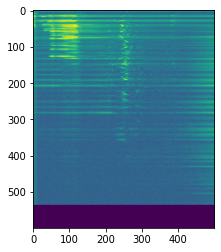

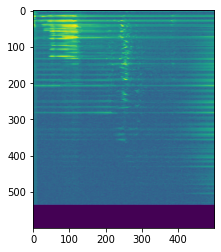

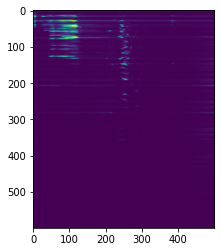

In [ ]:
plt.imshow(test_img_data1[0,...])
plt.show()
plt.imshow(test_img_data1b[0,...])
plt.show()
plt.imshow(test_img_data2[0,...])
plt.show()

In [ ]:
dertest=[]
for key in tqdm(submission.sample_id.values):
    if metadata.loc[metadata.index==key,'derivatized'].values[0]==1:
        dertest.append(1)
    else:
        dertest.append(0)
dertest=np.array(dertest)


100%|██████████| 775/775 [00:00<00:00, 2491.81it/s]


In [ ]:
labelsOnetest=[('').join(x.astype(str)) for x in val_labels.values]
len(np.unique(labelsOnetest))  ,len(labelsOnetest)

(22, 312)

In [ ]:
der.mean(),dertest.mean(),dertest[:312].mean(),dertest[312:].mean()

(0.315203955500618,
 0.39483870967741935,
 0.4583333333333333,
 0.35205183585313177)

In [ ]:
# EXTEND TRAIN DATA WITH PUPLIC LB 
train_img_data1=np.concatenate((train_img_data1, test_img_data1[:len(val_labels),...]))
train_img_data1b=np.concatenate((train_img_data1b, test_img_data1b[:len(val_labels),...]))
train_img_data2=np.concatenate((train_img_data2, test_img_data2[:len(val_labels),...]))
labels=np.concatenate((labels, val_labels))
der=np.concatenate((der, dertest[:len(val_labels),...]))
labelsOne=np.concatenate((np.array(labelsOne), np.array(labelsOnetest)[:len(val_labels),...]))

train_img_data1.shape, train_img_data1b.shape, train_img_data2.shape, labels.shape, der.shape, labelsOne.shape

((1121, 600, 500),
 (1121, 600, 500),
 (1121, 600, 500),
 (1121, 9),
 (1121,),
 (1121,))

In [ ]:
# train_img_data1=train_img_data1[:,:520,:]
# test_img_data1=test_img_data1[:,:520,:]
# train_img_data1.shape

In [ ]:
data_maxes2=np.concatenate((np.mean(train_img_data1,-1).astype('float')/255-0.5,
                            np.std(train_img_data1,-1).astype('float')/255-0.5,
                            sp.skew(train_img_data1,-1).astype('float')/255-0.5,
                            np.mean(train_img_data1,-2).astype('float')/255-0.5, 
                            np.expand_dims(der,-1)
                            ),1)

data_test_maxes2=np.concatenate((np.mean(test_img_data1,-1).astype('float')/255-0.5,
                            np.std(test_img_data1,-1).astype('float')/255-0.5,
                            sp.skew(test_img_data1,-1).astype('float')/255-0.5,
                            np.mean(test_img_data1,-2).astype('float')/255-0.5, 
                            np.expand_dims(dertest,-1)
                            ),1)

data_maxes2.shape,data_test_maxes2.shape

((1121, 2301), (775, 2301))

In [ ]:
model_name='PH2L1Rlogreg'

allfolds=[]
oof=np.zeros((len(data_maxes2), 9))
NUM_FOLDS=5
all_test_preds=np.zeros((submission.shape[0],9))
skf = StratifiedKFold(n_splits=NUM_FOLDS, random_state=42, shuffle=True)
fold=0
for train_index, test_index in skf.split(data_maxes2, labelsOne):
    test_preds=[]
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = data_maxes2[train_index,:], data_maxes2[test_index,:]
    y_train, y_test = labels[train_index].astype(float), labels[test_index].astype(float)

    # X_train=X_train[np.sum(y_train,1)>0,:]
    # y_train=y_train[np.sum(y_train,1)>0,:]

    from sklearn.linear_model import LogisticRegression

    from sklearn.metrics import log_loss
    loss_pre_class=[]
    for i in range(y_train.shape[1]):
        clf = LogisticRegression(random_state=0, max_iter=1000, tol=0.001, C=80.0).fit(X_train, y_train[:,i])
        # Save model
        # joblib.dump(clf, model_path+model_name+str(fold))
        # clf=joblib.load(model_path+model_name+str(fold))
        joblib.dump(clf, model_path+model_name+'_fold'+str(fold)+'_col'+str(i))
        clf=joblib.load(model_path+model_name+'_fold'+str(fold)+'_col'+str(i))
        #make Predictions
        preds=clf.predict_proba(X_test)[:,1]
        oof[test_index,i]=preds
        test_preds.append(clf.predict_proba(data_test_maxes2)[:,1])
        loss_pre_class.append(log_loss(y_test[:,i], np.clip(preds, 0.001, 0.93)))
    
    print(np.mean(loss_pre_class))
    allfolds.append(np.mean(loss_pre_class))
    test_preds=np.stack(test_preds).T   
    all_test_preds += test_preds/NUM_FOLDS
    fold+=1
# all_test_preds =  np.clip(all_test_preds, 0.001, 0.93)
print(np.mean(allfolds))    

# Save predictions
np.savez_compressed(oof_path+model_name, preds=oof)
submission2=submission.copy()
submission2.iloc[:,1:] = all_test_preds
submission2.to_csv(subs_path+model_name+'.csv', index=False)

oof_logreg=oof.copy()
test_logreg=all_test_preds.copy()
print_scores(oof_logreg, test_logreg )

0.12577504497145156
0.1111363033477518
0.11679281158865791
0.1299527565351471
0.1316169441072189
0.12305477211004545
oof score 0.12460474794987819
oof score, clipped per c 0.1205926304898077
val score 0.0534186257409733
val score, clipped per c 0.05643305379534742
mean score unclipped 0.08901168684542575


In [ ]:
data_maxes2=np.concatenate((np.mean(train_img_data1,-1).astype('float')/255,
                            np.max(train_img_data1,-1).astype('float')/255,
                            np.std(train_img_data1,-1).astype('float')/255,
                            np.mean(train_img_data1,-2).astype('float')/255, 
                            np.expand_dims(der,-1)),1)
data_test_maxes2=np.concatenate((np.mean(test_img_data1,-1).astype('float')/255,
                                 np.max(test_img_data1,-1).astype('float')/255,
                                 np.std(test_img_data1,-1).astype('float')/255,
                                np.mean(test_img_data1,-2).astype('float')/255, 
                                np.expand_dims(dertest,-1)),1)

data_maxes2.shape,data_test_maxes2.shape


((1121, 2301), (775, 2301))

In [ ]:
model_name='PH2L1Rrf'
from sklearn.ensemble import RandomForestClassifier


warnings.filterwarnings("ignore")
allfolds=[]
NUM_FOLDS=5
skf = StratifiedKFold(n_splits=NUM_FOLDS, random_state=42, shuffle=True)
oof=np.zeros((len(data_maxes2),9))
all_test_preds=np.zeros((submission.shape[0],9))
all_feat_imps=[]
fold=0
for train_index, test_index in skf.split(data_maxes2, labelsOne):
    test_preds=[]
    X_train, X_test = data_maxes2[train_index,:], data_maxes2[test_index,:]
    y_train, y_test = labels[train_index].astype(float), labels[test_index].astype(float)


    loss_pre_class=[]
    for i in range(y_train.shape[1]):
        rf = RandomForestClassifier(n_estimators=300, criterion='gini', max_depth=None, min_samples_split=2, 
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', 
                            max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, 
                            oob_score=False, n_jobs=8, random_state=42, verbose=0, 
                            warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

        rf.fit(X_train, y_train[:,i])    

        # Save model
        joblib.dump(rf, model_path+model_name+'_fold'+str(fold)+'_col'+str(i))
        rf=joblib.load(model_path+model_name+'_fold'+str(fold)+'_col'+str(i))

        all_feat_imps.append(rf.feature_importances_)
        preds = rf.predict_proba(X_test)[:,1]
        test_preds.append(rf.predict_proba(data_test_maxes2)[:,1])
        oof[test_index,i] = preds
        loss_pre_class.append(log_loss(y_test[:,i], preds))
    test_preds=np.stack(test_preds).T
    all_test_preds += test_preds/NUM_FOLDS   
    print(np.mean(loss_pre_class))
    allfolds.append(np.mean(loss_pre_class))
    fold+=1
print(np.mean(allfolds))  
all_feat_imps=np.vstack(all_feat_imps)

# Save predictions
np.savez_compressed(oof_path+model_name, preds=oof)
submission2=submission.copy()
submission2.iloc[:,1:] = all_test_preds
submission2.to_csv(subs_path+model_name+'.csv', index=False)

oof_rf=oof.copy()
all_test_preds_rf=all_test_preds.copy()
print_scores(oof_rf, all_test_preds_rf )

0.1541536431072656
0.1361860109906976
0.13711900624088436
0.16657189449154927
0.21580031053393067
0.16196617307286548
oof score 0.16195920382222717
oof score, clipped per c 0.14536209260402205
val score 0.05558134721763511
val score, clipped per c 0.0567961838153637
mean score unclipped 0.10877027551993114


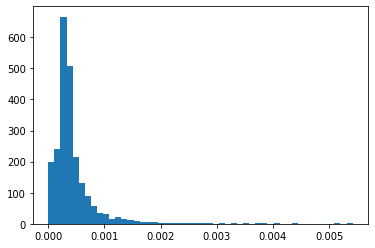

In [ ]:

plt.hist(np.mean(all_feat_imps,0),50)
plt.show()

In [ ]:
model_name='PH2L1Rridge'

from sklearn.linear_model import RidgeClassifier
cols=np.where(np.mean(all_feat_imps,0)>0.0001)[0]
# cols=np.arange(data_maxes2.shape[1])
print(len(cols))

ridge = RidgeClassifier(alpha=0.1, fit_intercept=True, normalize=False, 
                        copy_X=True, max_iter=None, tol=0.01, class_weight=None, 
                        solver='auto',  random_state=42)

allfolds=[]
NUM_FOLDS=5
skf = StratifiedKFold(n_splits=NUM_FOLDS, random_state=42, shuffle=True)
oof=np.zeros((len(data_maxes2),9))
all_test_preds=np.zeros((submission.shape[0],9))
fold=0
for train_index, test_index in skf.split(data_maxes2, labelsOne):
    test_preds=[]
    X_train, X_test = data_maxes2[train_index,:][:,cols], data_maxes2[test_index,:][:,cols]
    y_train, y_test = labels[train_index].astype(float), labels[test_index].astype(float)


    loss_pre_class=[]
    for i in range(y_train.shape[1]):
        model = ridge.fit(X_train, y_train[:,i])#,

        # Save model
        joblib.dump(model, model_path+model_name+'_fold'+str(fold)+'_col'+str(i))
        model=joblib.load(model_path+model_name+'_fold'+str(fold)+'_col'+str(i))

        preds = model.predict(X_test)
        test_preds.append(model.predict(data_test_maxes2[:,cols]))
        oof[test_index,i] = preds
        loss_pre_class.append(log_loss(y_test[:,i], np.clip(preds, 0.04, 0.9)))
    test_preds=np.stack(test_preds).T
    all_test_preds += test_preds/NUM_FOLDS   
    print(np.mean(loss_pre_class))
    allfolds.append(np.mean(loss_pre_class))
    fold+=1
print(np.mean(allfolds))   

# Save predictions
np.savez_compressed(oof_path+model_name, preds=oof)
submission2=submission.copy()
submission2.iloc[:,1:] = all_test_preds
submission2.to_csv(subs_path+model_name+'.csv', index=False)

oof_ridge=oof.copy()
all_test_preds_ridge=all_test_preds.copy()
print_scores(oof_ridge, all_test_preds_ridge )

2102
0.19185925914160315
0.14748952331020931
0.17237451171547014
0.1610243502836636
0.17682684446053126
0.16991489778229546
oof score 1.5165835539415486
oof score, clipped per c 0.1585061919745582
val score 0.048670260293192755
val score, clipped per c 0.059625454159947994
mean score unclipped 0.7826269071173707


In [ ]:
data_maxes2=np.concatenate((np.mean(train_img_data1b,-1).astype('float')/255,
                            np.max(train_img_data1b,-1).astype('float')/255,
                            np.std(train_img_data1b,-1).astype('float')/255,
                            np.mean(train_img_data1b,-2).astype('float')/255, 
                            np.expand_dims(der,-1)),1)

data_test_maxes2=np.concatenate((np.mean(test_img_data1b,-1).astype('float')/255,
                                 np.max(test_img_data1b,-1).astype('float')/255,
                                 np.std(test_img_data1b,-1).astype('float')/255,
                                np.mean(test_img_data1b,-2).astype('float')/255, 
                                np.expand_dims(dertest,-1)),1)

In [ ]:
model_name='PH2L1Rrfb'
from sklearn.ensemble import RandomForestClassifier


warnings.filterwarnings("ignore")
allfolds=[]
NUM_FOLDS=5
skf = StratifiedKFold(n_splits=NUM_FOLDS, random_state=42, shuffle=True)
oof=np.zeros((len(data_maxes2),9))
all_test_preds=np.zeros((submission.shape[0],9))
all_feat_impsb=[]
fold=0
for train_index, test_index in skf.split(data_maxes2, labelsOne):
    test_preds=[]
    X_train, X_test = data_maxes2[train_index,:], data_maxes2[test_index,:]
    y_train, y_test = labels[train_index].astype(float), labels[test_index].astype(float)


    loss_pre_class=[]
    for i in range(y_train.shape[1]):
        rf = RandomForestClassifier(n_estimators=300, criterion='gini', max_depth=None, min_samples_split=2, 
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', 
                            max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, 
                            oob_score=False, n_jobs=8, random_state=42, verbose=0, 
                            warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

        rf.fit(X_train, y_train[:,i])    

        # Save model
        joblib.dump(rf, model_path+model_name+'_fold'+str(fold)+'_col'+str(i))
        rf=joblib.load(model_path+model_name+'_fold'+str(fold)+'_col'+str(i))
        
        all_feat_impsb.append(rf.feature_importances_)
        preds = rf.predict_proba(X_test)[:,1]
        test_preds.append(rf.predict_proba(data_test_maxes2)[:,1])
        oof[test_index,i] = preds
        loss_pre_class.append(log_loss(y_test[:,i], preds))
    test_preds=np.stack(test_preds).T
    all_test_preds += test_preds/NUM_FOLDS   
    print(np.mean(loss_pre_class))
    allfolds.append(np.mean(loss_pre_class))
    fold+=1
print(np.mean(allfolds))  
all_feat_impsb=np.vstack(all_feat_impsb)

# Save predictions
np.savez_compressed(oof_path+model_name, preds=oof)
submission2=submission.copy()
submission2.iloc[:,1:] = all_test_preds
submission2.to_csv(subs_path+model_name+'.csv', index=False)

oof_rfb=oof.copy()
all_test_preds_rfb=all_test_preds.copy()
print_scores(oof_rfb, all_test_preds_rfb )

0.15576608043865425
0.13732056114047803
0.15162340129395913
0.1686552811021528
0.1886483297648691
0.16040273074802266
oof score 0.16039859457468691
oof score, clipped per c 0.14671585922527938
val score 0.05528951582934197
val score, clipped per c 0.05600580330413967
mean score unclipped 0.10784405520201444


In [ ]:


model_name='PH2L1Rridge0'

from sklearn.linear_model import RidgeClassifier
cols=np.where(np.mean(all_feat_impsb,0)>0.00005)[0]
cols=np.where(np.mean(all_feat_impsb,0)>0.0002)[0]
# cols=np.arange(data_maxes2.shape[1])
print(len(cols))

ridge = RidgeClassifier(alpha=0.2, fit_intercept=True, normalize=False, 
# ridge = RidgeClassifier(alpha=0.25, fit_intercept=True, normalize=False, 
                        copy_X=True, max_iter=None, tol=0.01, class_weight=None, 
                        solver='auto',  random_state=42)

allfolds=[]
NUM_FOLDS=5
skf = StratifiedKFold(n_splits=NUM_FOLDS, random_state=42, shuffle=True)
oof=np.zeros((len(data_maxes2),9))
all_test_preds=np.zeros((submission.shape[0],9))
fold=0
for train_index, test_index in skf.split(data_maxes2, labelsOne):
    test_preds=[]
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = data_maxes2[train_index,:][:,cols], data_maxes2[test_index,:][:,cols]
    y_train, y_test = labels[train_index].astype(float), labels[test_index].astype(float)


    loss_pre_class=[]
    for i in range(y_train.shape[1]):
        model = ridge.fit(X_train, y_train[:,i])#,

        # Save model
        joblib.dump(model, model_path+model_name+'_fold'+str(fold)+'_col'+str(i))
        model=joblib.load(model_path+model_name+'_fold'+str(fold)+'_col'+str(i))        

        preds = model.predict(X_test)
        test_preds.append(model.predict(data_test_maxes2[:,cols]))
        oof[test_index,i] = preds
        loss_pre_class.append(log_loss(y_test[:,i], np.clip(preds, 0.04, 0.9)))
    test_preds=np.stack(test_preds).T
    all_test_preds += test_preds/NUM_FOLDS   
    print(np.mean(loss_pre_class))
    allfolds.append(np.mean(loss_pre_class))
    fold+=1
print(np.mean(allfolds))   

# Save predictions
np.savez_compressed(oof_path+model_name, preds=oof)
submission2=submission.copy()
submission2.iloc[:,1:] = all_test_preds
submission2.to_csv(subs_path+model_name+'.csv', index=False)

oof_ridge0=oof.copy()
all_test_preds_ridge0=all_test_preds.copy()
print_scores(oof_ridge0, all_test_preds_ridge0 )

1950
0.17999375698235617
0.14917950785532164
0.15203461622625175
0.15219468200288266
0.16798292598606415
0.16027709781057528
oof score 1.3693735462429997
oof score, clipped per c 0.15201807870145947
val score 0.13424290635486363
val score, clipped per c 0.0622376287520053
mean score unclipped 0.7518082262989316


In [ ]:

import tensorflow as tf
import tensorflow.keras as keras

#from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, concatenate, Flatten, BatchNormalization
from tensorflow.keras.layers import LSTM, Reshape, Bidirectional, Concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, SeparableConv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, AveragePooling1D
from tensorflow.keras.models import Model
import gc
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
    
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Input, Concatenate, Conv2D, Dropout, Reshape

from tensorflow.keras import regularizers
import tensorflow.keras.backend as K

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:

def train_model(NUM_FOLDS=5, best=True, epochs=20, SNAPSHOTS=1, BATCH_SIZE=16, 
                lr_0=0.0001, SEEDNUM=42, verbose=1, dataform=1):

    # LR schedule
    epochspersnapshot = int(epochs/SNAPSHOTS)
    def _cosine_anneal_schedule(t):
        cos_inner = np.pi * (t % (epochs // SNAPSHOTS))
        cos_inner /= epochs // SNAPSHOTS
        cos_out = np.cos(cos_inner) + 1
        return float(lr_0 / 2 * cos_out)
    lr_anneal = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)
    np.array([_cosine_anneal_schedule(t) for t in range( int(epochs/SNAPSHOTS))])

    # Data Preprocess
    

    if dataform==1:
        data_maxes2=np.concatenate((np.mean(train_img_data,-1).astype('float')/255,
            np.max(train_img_data,-1).astype('float')/255, np.std(train_img_data,-1).astype('float')/255,
            np.mean(train_img_data,-2).astype('float')/255, # np.std(train_img_data,-2).astype('float')/255, 
            np.expand_dims(der,-1)),1)
        data_test_maxes2=np.concatenate((np.mean(test_img_data,-1).astype('float')/255,
            np.max(test_img_data,-1).astype('float')/255, np.std(test_img_data,-1).astype('float')/255,
            # sp.skew(test_img_data,-1).astype('float')/255, np.expand_dims(test_gx,-1)/ max(np.max(test_gx),np.max(test_gx)),
            np.mean(test_img_data,-2).astype('float')/255, # np.std(test_img_data,-2).astype('float')/255, 
            np.expand_dims(dertest,-1)),1)
    elif dataform==2:
        data_maxes2=np.concatenate((np.mean(train_img_data,-1).astype('float')/255,
            np.max(train_img_data,-1).astype('float')/255, np.std(train_img_data,-1).astype('float')/255,
            sp.skew(train_img_data,-1).astype('float')/255, #np.expand_dims(train_gx,-1)/ max(np.max(train_gx),np.max(test_gx)),
            np.mean(train_img_data,-2).astype('float')/255, #np.std(train_img_data,-2).astype('float')/255, 
            np.expand_dims(der,-1)),1)
        data_test_maxes2=np.concatenate((np.mean(test_img_data,-1).astype('float')/255,
            np.max(test_img_data,-1).astype('float')/255, np.std(test_img_data,-1).astype('float')/255,
            sp.skew(test_img_data,-1).astype('float')/255, #np.expand_dims(test_gx,-1)/ max(np.max(test_gx),np.max(test_gx)),
            np.mean(test_img_data,-2).astype('float')/255, #np.std(test_img_data,-2).astype('float')/255, 
            np.expand_dims(dertest,-1)),1)
    elif dataform==3:
        data_maxes2=np.concatenate((np.mean(train_img_data,-1).astype('float')/255,
            np.std(train_img_data,-1).astype('float')/255,
            np.mean(train_img_data,-2).astype('float')/255, #np.std(train_img_data,-2).astype('float')/255, 
            np.expand_dims(der,-1)),1)
        data_test_maxes2=np.concatenate((np.mean(test_img_data,-1).astype('float')/255,
            np.std(test_img_data,-1).astype('float')/255,
            np.mean(test_img_data,-2).astype('float')/255, #np.std(test_img_data,-2).astype('float')/255, 
            np.expand_dims(dertest,-1)),1)     
    elif dataform==4:
        data_maxes2=np.concatenate((np.mean(train_img_data,-1).astype('float')/255-0.5,
            np.std(train_img_data,-1).astype('float')/255-0.5,
            (sp.skew(train_img_data,-1).astype('float')/255+1)**3, #np.expand_dims(train_gx,-1)/ max(np.max(train_gx),np.max(test_gx)),
            np.mean(train_img_data,-2).astype('float')/700-0.5, #np.std(train_img_data,-2).astype('float')/255, 
            np.expand_dims(der,-1)),1)
        data_test_maxes2=np.concatenate((np.mean(test_img_data,-1).astype('float')/255-0.5,
            np.std(test_img_data,-1).astype('float')/255-0.5,
            (sp.skew(test_img_data,-1).astype('float')/255+1)**3, #np.expand_dims(test_gx,-1)/ max(np.max(test_gx),np.max(test_gx)),
            np.mean(test_img_data,-2).astype('float')/255-0.5, #np.std(test_img_data,-2).astype('float')/255, 
            np.expand_dims(dertest,-1)),1)        
    elif dataform==5:
        data_maxes2=np.concatenate((np.mean(train_img_data,-1).astype('float')/255,
            np.max(train_img_data,-1).astype('float')/255, 
            np.std(train_img_data,-1).astype('float')/255,
            np.mean(train_img_data,-2).astype('float')/255, np.std(train_img_data,-2).astype('float')/255, 
            np.expand_dims(der,-1)),1)
        data_test_maxes2=np.concatenate((np.mean(test_img_data,-1).astype('float')/255,
            np.max(test_img_data,-1).astype('float')/255, 
            np.std(test_img_data,-1).astype('float')/255,
            np.mean(test_img_data,-2).astype('float')/255, np.std(test_img_data,-2).astype('float')/255, 
            np.expand_dims(dertest,-1)),1)    
    elif dataform==6:
        data_maxes2=np.concatenate((np.mean(train_img_data,-1).astype('float')/255,
            np.max(train_img_data,-1).astype('float')/255, 
            np.std(train_img_data,-1).astype('float')/255,
            np.mean(train_img_data,-2).astype('float')/255, np.std(train_img_data,-2).astype('float')/255, 
            extrafeats_train,
            np.expand_dims(der,-1)),1)
        data_test_maxes2=np.concatenate((np.mean(test_img_data,-1).astype('float')/255,
            np.max(test_img_data,-1).astype('float')/255, 
            np.std(test_img_data,-1).astype('float')/255,
            np.mean(test_img_data,-2).astype('float')/255, np.std(test_img_data,-2).astype('float')/255, 
            extrafeats_test,
            np.expand_dims(dertest,-1)),1)             

    # training
    allfolds=[]
    skf = StratifiedKFold(n_splits=NUM_FOLDS, random_state=42, shuffle=True)
    oof=np.zeros((len(data_maxes2),9))
    all_test_preds=np.zeros((submission.shape[0],9))
    fold=0
    for train_index, test_index in skf.split(data_maxes2, labelsOne):
        loss_per_class=[]
        set_seed(seed=SEEDNUM)
        X_train, X_test = data_maxes2[train_index,:], data_maxes2[test_index,:]
        y_train, y_test = labels[train_index].astype(float), labels[test_index].astype(float)

    
        model=get_model_simple(dim=(data_maxes2.shape[1],))     
        model.compile(loss=keras.losses.binary_crossentropy, metrics=['binary_crossentropy'],#metrics=["accuracy"],
                        optimizer=keras.optimizers.SGD(learning_rate=lr_0, momentum=0.9))#, clipvalue=1.0))#,  nesterov=True))


        history = model.fit(X_train,  y_train,
                            batch_size=BATCH_SIZE,
                            epochs=epochs,
                            shuffle=True,
                            validation_data=(X_test, y_test),
                            callbacks=[#lr_sch, 
                                    lr_anneal,
                                    tf.keras.callbacks.ModelCheckpoint(model_path+model_name+'_fold'+str(fold)+'_seed'+str(SEEDNUM)+'.h5',
                                                                        monitor='val_loss', verbose=0, save_best_only=True,
                                                                        save_weights_only=True, mode='auto', 
                                                                        save_freq='epoch')
                                    # ,EarlyStopping(monitor="val_loss", min_delta=0, patience=30, verbose=0,
                                    #                mode="auto", baseline=None, restore_best_weights=False)
                            ],
                            verbose = verbose )
        if best==True:
            model.load_weights(model_path+model_name+'_fold'+str(fold)+'_seed'+str(SEEDNUM)+'.h5')

        # Predictions
        preds = model.predict(X_test)#[:,1]
        test_preds=model.predict(data_test_maxes2)

        oof[test_index,:] = preds 
        all_test_preds += test_preds/NUM_FOLDS                  
            
            
        loss_per_class= [log_loss(y_test[:,x], oof[test_index,x]) for x in range(9)]
        print(np.mean(loss_per_class))
        allfolds.append(np.mean(loss_per_class))
        del  model
        K.clear_session()
        gc.collect()
        fold+=1
    print(np.mean(allfolds))    
    return oof, all_test_preds

In [ ]:
from tensorflow.keras.layers import LayerNormalization, Attention

ACTIVATION='swish'
def get_model_simple(num_outputs=9, dim=(data_maxes2.shape[1],),  out_activation='sigmoid'):
    tf.keras.backend.clear_session()
    gc.collect()

    input_layer = Input(shape=(dim), name='input_layer')
    
    x = Dense(400, activation=ACTIVATION)(input_layer)
    # x1 = LayerNormalization()(x)
    # x = Attention(use_scale=True)([x, x])
    x1 = BatchNormalization()(x)
#     x1 = Dropout(0.1)(x1)

    x = Dense(300, activation=ACTIVATION)(x1)
    # x = LayerNormalization()(x)
    # x = Attention(use_scale=True)([x, x])
    x = BatchNormalization()(x)
#     x = Concatenate()([x1, x])
    x = Dense(200, activation=ACTIVATION)(x)
    # x = LayerNormalization()(x)
    # x = Attention(use_scale=True)([x, x])
    x = BatchNormalization()(x)
#     x = Dense(100, activation=ACTIVATION)(x)
#     x = BatchNormalization()(x)
    output = Dense(num_outputs, activation=out_activation)(x)
    model = Model(input_layer, output)
    # model = Model([input_layer,input_layer2], output)
    return model

In [ ]:
model_name='PH2L1Rgpukeras'

In [ ]:
oof_simpleA, all_test_preds_simpleA=[],[] 
# for num_mz in [490,500,510,520,530]:
for num_mz in [500]:
# for num_mz in range(480,540,20):
    print(num_mz)
    train_img_data=train_img_data2.copy()
    train_img_data=train_img_data2[:,:num_mz,:]
    test_img_data=test_img_data2.copy()
    test_img_data=test_img_data2[:,:num_mz,:]
    # MEAN,STD=np.mean(np.concatenate((train_img_data,test_img_data)).astype('float')/255.),np.std(np.concatenate((train_img_data,test_img_data)).astype('float')/255.)
    oof_simple, all_test_preds_simple = train_model(NUM_FOLDS=5, best=True,
                epochs=80, SNAPSHOTS=1, BATCH_SIZE=32, lr_0=0.01, SEEDNUM=42, verbose=1, dataform=5)
    oof_simple2, all_test_preds_simple2 = train_model(NUM_FOLDS=5, best=True,
                epochs=80, SNAPSHOTS=1, BATCH_SIZE=32, lr_0=0.01, SEEDNUM=2022, verbose=0, dataform=5)
    oof_simple3, all_test_preds_simple3 = train_model(NUM_FOLDS=5, best=True,
                epochs=80, SNAPSHOTS=1, BATCH_SIZE=32, lr_0=0.01, SEEDNUM=22, verbose=0, dataform=5)
    oof_simpleA.append([oof_simple,oof_simple2,oof_simple3])
    all_test_preds_simpleA.append([all_test_preds_simple,all_test_preds_simple2,all_test_preds_simple3])
    print_scores(oof_simple, all_test_preds_simple)
    print_scores(oof_simple2, all_test_preds_simple2)
    print_scores(oof_simple3, all_test_preds_simple3)
    print_scores((oof_simple+oof_simple2+oof_simple3)/3, (all_test_preds_simple+all_test_preds_simple2+all_test_preds_simple3)/3)
    print('-------------------------------------------------')

In [ ]:
# Save predictions
oof = np.mean(np.stack(oof_simpleA[0]),0)
all_test_preds = np.mean(np.stack(all_test_preds_simpleA[0]),0)
np.savez_compressed(oof_path+model_name, preds=oof)
submission2=submission.copy()
submission2.iloc[:,1:] = all_test_preds
submission2.to_csv(subs_path+model_name+'.csv', index=False)

oof_keras=oof.copy()
all_test_preds_keras=all_test_preds.copy()
print_scores(oof_keras, all_test_preds_keras )


oof score 0.11713394658848915
oof score, clipped per c 0.11647513291103019
val score 0.04662815332617154
val score, clipped per c 0.046997346006847115
mean score unclipped 0.08188104995733034


In [ ]:
|

In [ ]:
def train_model_cnn(model_type, preprocess='unscaled', NUM_FOLDS=5, best=True,
                epochs=20, SNAPSHOTS=1, BATCH_SIZE=16, lr_0=0.0001, SEEDNUM=42,
                verbose=1):

    # LR schedule
    epochspersnapshot = int(epochs/SNAPSHOTS)
    def _cosine_anneal_schedule(t):
        cos_inner = np.pi * (t % (epochs // SNAPSHOTS))
        cos_inner /= epochs // SNAPSHOTS
        cos_out = np.cos(cos_inner) + 1
        return float(lr_0 / 2 * cos_out)
    lr_anneal = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)
    np.array([_cosine_anneal_schedule(t) for t in range( int(epochs/SNAPSHOTS))])

    # Data Preprocess  
    
    if preprocess=='standard_scale':
        data_maxes2 = train_img_data.astype('float')/255.
        data_maxes2= (data_maxes2-MEAN)/ STD
    elif preprocess=='zero_one':
        data_maxes2 = train_img_data.astype('float')/255.
    elif preprocess=='unscaled':
        data_maxes2 = train_img_data.astype('float')
    elif preprocess=='minus_plus_one':
        data_maxes2 = train_img_data.astype('float')/127.5 - 1

    # training
    allfolds=[]
    skf = StratifiedKFold(n_splits=NUM_FOLDS, random_state=42, shuffle=True)
    oof=np.zeros((len(data_maxes2),9))
    all_test_preds=np.zeros((submission.shape[0],9))
    fold=0
    for train_index, test_index in skf.split(data_maxes2, labelsOne):
        loss_per_class=[]
        set_seed(seed=SEEDNUM)
        X_train, X_test = data_maxes2[train_index,:], data_maxes2[test_index,:]
        y_train, y_test = labels[train_index].astype(float), labels[test_index].astype(float)

        X_train, X_test =  np.transpose(X_train, axes = (0,2,1)),  np.transpose(X_test, axes = (0,2,1))
        
        
        # Load model
        if model_type=='CNN0':
            model=get_model_cnn(9, dim=(data_maxes2.shape[1:][::-1]), EFF=0 )
        elif model_type=='CNN1':
            model=get_model_cnn(9, dim=(data_maxes2.shape[1:][::-1]), EFF=1 )
        elif model_type=='CNN2':
            model=get_model_cnn(9, dim=(data_maxes2.shape[1:][::-1]), EFF=2 )
        elif model_type=='CNN3':
            model=get_model_cnn(9, dim=(data_maxes2.shape[1:][::-1]), EFF=3 )            

        # model.compile(loss=keras.losses.binary_crossentropy, metrics=["accuracy"], optimizer=keras.optimizers.Adam(learning_rate=lr_0, beta_1=0.8))
        model.compile(loss=keras.losses.binary_crossentropy, metrics=["accuracy"], 
                          optimizer=keras.optimizers.SGD(learning_rate=lr_0, momentum=0.9))#, clipvalue=1.0))#,  nesterov=True))

        history = model.fit(X_train,  y_train,
                            batch_size=BATCH_SIZE,
                            # epochs=40,
                            epochs=epochs,
                            shuffle=True,
                            validation_data=(X_test, y_test),
                            callbacks=[#lr_sch, 
                                    lr_anneal,
                                    tf.keras.callbacks.ModelCheckpoint(model_path+model_name+'_fold'+str(fold)+'_seed'+str(SEEDNUM)+'.h5',
                                                                        monitor='val_loss', verbose=0, save_best_only=True,
                                                                        save_weights_only=True, mode='auto', 
                                                                        save_freq='epoch')
                            ],
                            verbose = verbose )
        if best==True:
            model.load_weights(model_path+model_name+'_fold'+str(fold)+'_seed'+str(SEEDNUM)+'.h5')

        # Predictions
        preds = model.predict(X_test)#[:,1]
        if preprocess=='standard_scale':
            test_preds=model.predict(np.transpose((test_img_data/255.-MEAN)/ STD, axes = (0,2,1)))
        elif preprocess=='zero_one':
            test_preds=model.predict(np.transpose(test_img_data/255., axes = (0,2,1)))
        elif preprocess=='unscaled':
            test_preds=model.predict(np.transpose(test_img_data, axes = (0,2,1)))
        elif preprocess=='minus_plus_one':
            test_preds=model.predict(np.transpose(test_img_data/127.5 -1, axes = (0,2,1)))

        oof[test_index,:] = preds 
        # test_preds=np.stack(test_preds).T
        all_test_preds += test_preds/NUM_FOLDS                  
            
            
        loss_per_class= [log_loss(y_test[:,x], oof[test_index,x]) for x in range(9)]
        print(np.mean(loss_per_class))
        allfolds.append(np.mean(loss_per_class))
        del  model
        K.clear_session()
        gc.collect()
        fold+=1
    print(np.mean(allfolds))    
    return oof, all_test_preds    

In [ ]:
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
from tensorflow.keras.layers import RandomTranslation, RandomContrast

def get_model_cnn(num_outputs=9, dim=(500,500), EFF=1):
    # create the base pre-trained model


    img_input = Input(shape=dim)



    x = RandomTranslation(height_factor=0.0, width_factor=0.05,  fill_mode="constant",
        interpolation="bilinear",    seed=None,    fill_value=0)(img_input)
    x= RandomContrast(0.1)(x)
    # x= RandomFlip(mode='horizontal')(x)
    # x= RandomBrightness(factor=0.1, value_range=(-0., 15))(x)
    # x= img_input


    xa = GlobalMaxPooling1D(data_format='channels_last')(img_input)
    xb = GlobalAveragePooling1D(data_format='channels_last')(img_input)
    xc = GlobalAveragePooling1D(data_format='channels_first')(img_input)
    xabc = Concatenate()([xa, xb, xc])
    xabc = Dense(512, activation='relu')(xabc)

#     x = AveragePooling1D(pool_size=3, data_format="channels_last")(img_input) # smooth
    x = MaxPooling1D(pool_size=10, data_format="channels_last")(x)

    x = Reshape((50,500,1))(x)
    # x = Reshape((100,500,1))(x)
#     x = Reshape((33,500,1))(x)
    img_conc = Concatenate()([x, x, x])    
    # img_conc = Concatenate()([img_input, img_input, img_input])    
#     base_model = ResNet50(weights='imagenet', include_top=False,
#                                  input_tensor=img_conc
#                                 # input_shape=(500,500,3)
#     )
    # base_model = DenseNet201(weights='imagenet', include_top=False,
    #                              input_tensor=img_conc
    #                             # input_shape=(500,500,3)
    # )
    if EFF==0:
        base_model = EfficientNetB0(weights='imagenet', include_top=False,
                                    input_tensor=img_conc        )
    elif EFF==1:
        base_model = EfficientNetB1(weights='imagenet', include_top=False,
                                    input_tensor=img_conc        )
    elif EFF==2:
        base_model = EfficientNetB2(weights='imagenet', include_top=False,
                                    input_tensor=img_conc        )
    elif EFF==3:
        base_model = EfficientNetB3(weights='imagenet', include_top=False,
                                    input_tensor=img_conc        )
        
    x = base_model.output

  
    x0 = GlobalMaxPooling2D()(x)
    x1 = GlobalAveragePooling2D()(x)
    x = Concatenate()([x0, x1, xabc])
    x = Dropout(0.25)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(num_outputs, activation='sigmoid')(x)

    model = Model(inputs=img_input, outputs=predictions)
    return model
model=get_model_cnn()

27018416/27018416 [==============================] - 0s 0us/step


In [ ]:
model_name='PH2L1RgpukerasEFF012'

oof_simpleA, all_test_preds_simpleA=[],[] 
# for num_mz in [490,500,510,520,530]:
for num_mz in [500]:
# for num_mz in range(480,540,20):
    print(num_mz)
    train_img_data=train_img_data2.copy()
    train_img_data=train_img_data2[:,:num_mz,:]
    test_img_data=test_img_data2.copy()
    test_img_data=test_img_data2[:,:num_mz,:]
    # MEAN,STD=np.mean(np.concatenate((train_img_data,test_img_data)).astype('float')/255.),np.std(np.concatenate((train_img_data,test_img_data)).astype('float')/255.)
    oof_simple, all_test_preds_simple = train_model_cnn(model_type='CNN0', preprocess='unscaled', NUM_FOLDS=5, best=True,
                epochs=40, SNAPSHOTS=1, BATCH_SIZE=32, lr_0=0.01, SEEDNUM=42, verbose=1)
    oof_simple2, all_test_preds_simple2 = train_model_cnn(model_type='CNN1', preprocess='unscaled', NUM_FOLDS=5, best=True,
                epochs=40, SNAPSHOTS=1, BATCH_SIZE=32, lr_0=0.01, SEEDNUM=2022, verbose=0)
    oof_simple3, all_test_preds_simple3 = train_model_cnn(model_type='CNN2', preprocess='unscaled', NUM_FOLDS=5, best=True,
                epochs=40, SNAPSHOTS=1, BATCH_SIZE=32, lr_0=0.01, SEEDNUM=22, verbose=0)
    oof_simpleA.append([oof_simple,oof_simple2,oof_simple3])
    all_test_preds_simpleA.append([all_test_preds_simple,all_test_preds_simple2,all_test_preds_simple3])
    print_scores(oof_simple, all_test_preds_simple)
    print_scores(oof_simple2, all_test_preds_simple2)
    print_scores(oof_simple3, all_test_preds_simple3)
    print_scores((oof_simple+oof_simple2+oof_simple3)/3, (all_test_preds_simple+all_test_preds_simple2+all_test_preds_simple3)/3)
    # print_scores((oof_simple+oof_simple2+oof_simple3+oof_lgbm)/4, (all_test_preds_simple+all_test_preds_simple2+all_test_preds_simple3+all_test_preds_lgbm)/4)
    print('-------------------------------------------------')

In [ ]:
# Save predictions
model_name='PH2L1RgpukerasEf012again'
oof = np.mean(np.stack(oof_simpleA[0]),0)
all_test_preds = np.mean(np.stack(all_test_preds_simpleA[0]),0)
np.savez_compressed(oof_path+model_name, preds=oof)
submission2=submission.copy()
submission2.iloc[:,1:] = all_test_preds
submission2.to_csv(subs_path+model_name+'.csv', index=False)

oof_keras_cnn=oof.copy()
all_test_preds_keras_cnn=all_test_preds.copy()
print_scores(oof_keras_cnn, all_test_preds_keras_cnn )


oof score 0.12275360969807564
oof score, clipped per c 0.12275360969807564
val score 0.08956284801207373
val score, clipped per c 0.08956284801207373
mean score unclipped 0.10615822885507468
